In [1]:
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from neo4j import GraphDatabase
from neo4_connection import USER, PWD, URL 

from sklearn import model_selection, metrics, preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from umap import UMAP

import torch
import torch.nn as nn
from torch.nn import Linear, MSELoss
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero, MetaPath2Vec
from torch_geometric.transforms import RandomLinkSplit, ToUndirected, AddSelfLoops, NormalizeFeatures

### Get data from Neo4j

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
driver = GraphDatabase.driver(uri=URL, auth=(USER, PWD))

def fetch_data(query):
  with driver.session() as session:
    result = session.run(query)
    return pd.DataFrame([r.values() for r in result], columns=result.keys())

### Preporcess neo4j database

In [4]:
def preprocess_neo4j_db(file_path:str) -> None:
    """Execute some type casts and data preprocessing steps on neo4j."""

    with open(file_path, mode='r', encoding='utf-8') as f:
        query = f.read()

    queries = [query for query in query.split(';')[:-1]] 

    with driver.session() as session:
        for query in queries:
            result = session.run(query)
            print(result)


preprocess_neo4j_db(file_path='./neo4j_cypher_queries/01_db_preprocessing.txt')

### Fetch data from neo4j

In [5]:
# User
query = """
MATCH (u:User)
RETURN u.userId as userId
"""

user_df = fetch_data(query)
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   userId  671 non-null    int64
dtypes: int64(1)
memory usage: 5.4 KB


In [6]:
# Movie
query = """
MATCH (m:Movie)
RETURN m.movieId as movieId
"""

movie_df = fetch_data(query)
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   movieId  9125 non-null   int64
dtypes: int64(1)
memory usage: 71.4 KB


In [7]:
# Actor
query = """
MATCH (a:Actor)
RETURN a.tmdbId as actorId
"""

actor_df = fetch_data(query)
actor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15443 entries, 0 to 15442
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   actorId  15443 non-null  int64
dtypes: int64(1)
memory usage: 120.8 KB


In [8]:
# Director
query = """
MATCH (d:Director)
RETURN d.tmdbId as directorId
"""

director_df = fetch_data(query)
director_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4091 entries, 0 to 4090
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   directorId  4091 non-null   int64
dtypes: int64(1)
memory usage: 32.1 KB


In [9]:
# Genre
query = """
MATCH (g:Genre)
RETURN g.name as genre
"""

genre_df = fetch_data(query)
genre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   genre   20 non-null     object
dtypes: object(1)
memory usage: 288.0+ bytes


In [10]:
query = """
MATCH (u:User) -[r:RATED]-> (m:Movie)
RETURN u.userId as userId
    ,r.rating as rating
    ,m.movieId as movieId
ORDER BY userId, movieId
"""

user_movie_df = fetch_data(query)
user_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   rating   100004 non-null  float64
 2   movieId  100004 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [11]:
query = """
MATCH (a:Actor) -[:ACTED_IN]-> (m:Movie)
RETURN m.movieId as movieId
    ,a.tmdbId as actorId
"""

movie_actor_df = fetch_data(query)
movie_actor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35910 entries, 0 to 35909
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   movieId  35910 non-null  int64
 1   actorId  35910 non-null  int64
dtypes: int64(2)
memory usage: 561.2 KB


In [12]:
query = """
MATCH (d:Director) -[:DIRECTED]-> (m:Movie)
RETURN m.movieId as movieId
    ,d.tmdbId as directorId
"""

movie_director_df = fetch_data(query)
movie_director_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10007 entries, 0 to 10006
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   movieId     10007 non-null  int64
 1   directorId  10007 non-null  int64
dtypes: int64(2)
memory usage: 156.5 KB


In [13]:
query = """
MATCH (m:Movie) -[:IN_GENRE]-> (g:Genre)
RETURN m.movieId as movieId
    ,g.name as genre
"""

movie_genre_df = fetch_data(query)
movie_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20340 entries, 0 to 20339
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  20340 non-null  int64 
 1   genre    20340 non-null  object
dtypes: int64(1), object(1)
memory usage: 317.9+ KB


In [14]:
user_liked_movie_df = user_movie_df[user_movie_df['rating'] >= 4.0].copy()
user_liked_movie_df.shape, user_liked_movie_df['rating'].value_counts()

((51568, 3),
 4.0    28750
 5.0    15095
 4.5     7723
 Name: rating, dtype: int64)

In [15]:
# Nodes
assert len(user_df) == 671, f'{user_df} length not as expected!'
assert len(movie_df) == 9125, f'{movie_df} length not as expected!'
assert len(actor_df) == 15443, f'{actor_df} length not as expected!'
assert len(director_df) == 4091, f'{director_df} length not as expected!'
assert len(genre_df) == 20, f'{genre_df} length not as expected!'

# Relations
assert len(user_movie_df) == 100004, f'{user_movie_df} length not as expected!'
assert len(movie_actor_df) == 35910, f'{movie_actor_df} length not as expected!'
assert len(movie_director_df) == 10007, f'{movie_director_df} length not as expected!'
assert len(movie_genre_df) == 20340, f'{movie_genre_df} length not as expected!'
assert len(user_liked_movie_df) == 51568, f'{user_liked_movie_df} length not as expected!'


In [16]:
N_USERS, N_MOVIES, N_ACTORS, N_DIRECTORS, N_GENRES = len(user_df), len(movie_df), len(actor_df), len(director_df), len(genre_df)

print(f'N_USERS: {N_USERS}\nN_MOVIES: {N_MOVIES}\nN_ACTORS: {N_ACTORS}\nN_DIRECTORS: {N_DIRECTORS}\nN_GENRES: {N_GENRES}')

N_USERS: 671
N_MOVIES: 9125
N_ACTORS: 15443
N_DIRECTORS: 4091
N_GENRES: 20


### Encoding & Scaling data

In [17]:
user_enc, movie_enc, actor_enc, director_enc, genre_enc = LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder()

In [18]:
# fit encoders
user_df['userId'] = user_enc.fit_transform(user_df['userId'])
movie_df['movieId'] = movie_enc.fit_transform(movie_df['movieId'])
actor_df['actorId'] = actor_enc.fit_transform(actor_df['actorId'])
director_df['directorId'] = director_enc.fit_transform(director_df['directorId'])
genre_df['genre'] = genre_enc.fit_transform(genre_df['genre'])

# transform Id's
user_movie_df['userId'] = user_enc.transform(user_movie_df['userId'])
user_movie_df['movieId'] = movie_enc.transform(user_movie_df['movieId'])

user_liked_movie_df['userId'] = user_enc.transform(user_liked_movie_df['userId'])
user_liked_movie_df['movieId'] = movie_enc.transform(user_liked_movie_df['movieId'])

movie_actor_df['movieId'] = movie_enc.transform(movie_actor_df['movieId'])
movie_actor_df['actorId'] = actor_enc.transform(movie_actor_df['actorId'])

movie_director_df['movieId'] = movie_enc.transform(movie_director_df['movieId'])
movie_director_df['directorId'] = director_enc.transform(movie_director_df['directorId'])

movie_genre_df['movieId'] = movie_enc.transform(movie_genre_df['movieId'])
movie_genre_df['genre'] = genre_enc.transform(movie_genre_df['genre'])

In [19]:
DO_SAFE = False

if DO_SAFE:
    user_df.to_csv(f'./datasets/ml100k_users.csv', index=False)
    movie_df.to_csv(f'./datasets/ml100k_movies.csv', index=False)
    actor_df.to_csv(f'./datasets/ml100k_actors.csv', index=False)
    director_df.to_csv(f'./datasets/ml100k_directors.csv', index=False)
    genre_df.to_csv(f'./datasets/ml100k_genres.csv', index=False)

    user_movie_df.to_csv(f'./datasets/ml100k_user-movie.csv', index=False)
    movie_actor_df.to_csv(f'./datasets/ml100k_movie-actor.csv', index=False)
    movie_director_df.to_csv(f'./datasets/ml100k_movie-director.csv', index=False)
    movie_genre_df.to_csv(f'./datasets/ml100k_movie-genre.csv', index=False)

### Create Pytorch Geometric (heterogenious) Dataset

In [20]:
x_user = torch.Tensor(user_df['userId'])
x_movie = torch.Tensor(movie_df['movieId'])
x_actor = torch.Tensor(actor_df['actorId'])
x_director = torch.Tensor(director_df['directorId'])
x_genre = torch.Tensor(genre_df['genre'])

LIMIT = 9
print(f'x_user: {x_user.size()}, {x_user[:LIMIT]}')
print(f'x_movie: {x_movie.size()}, {x_movie[:LIMIT]}')
print(f'x_actor: {x_actor.size()}, {x_actor[:LIMIT]}')
print(f'x_director: {x_director.size()}, {x_director[:LIMIT]}')
print(f'x_genre: {x_genre.size()}, {x_genre[:LIMIT]}')

x_user: torch.Size([671]), tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.])
x_movie: torch.Size([9125]), tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.])
x_actor: torch.Size([15443]), tensor([14347., 14941.,  2058.,  2059.,  2060.,  2061., 10763., 10765., 10762.])
x_director: torch.Size([4091]), tensor([2755., 1244.,  511., 3337.,  744.,  757.,  517.,  172.,  723.])
x_genre: torch.Size([20]), tensor([ 2.,  3.,  4.,  5.,  9., 15.,  8.,  1.,  6.])


In [21]:
edge_index_user_rated_movie = torch.Tensor(user_movie_df[['userId', 'movieId']].values).swapaxes(1,0).to(torch.long)
edge_index_user_liked_movie = torch.Tensor(user_liked_movie_df[['userId', 'movieId']].values).swapaxes(1,0).to(torch.long)
edge_index_actor_playedIn_movie = torch.Tensor(movie_actor_df[['actorId', 'movieId']].values).swapaxes(1,0).to(torch.long)
edge_index_director_directed_movie = torch.Tensor(movie_director_df[['directorId', 'movieId']].values).swapaxes(1,0).to(torch.long)
edge_index_movie_in_genre = torch.Tensor(movie_genre_df[['movieId', 'genre']].values).swapaxes(1,0).to(torch.long)

print(f'edge_index_user_rated_movie: {edge_index_user_rated_movie.size()}\n{edge_index_user_rated_movie[:,:LIMIT]}\n')
print(f'edge_index_user_liked_movie: {edge_index_user_liked_movie.size()}\n{edge_index_user_liked_movie[:,:LIMIT]}\n')
print(f'edge_index_actor_playedIn_movie: {edge_index_actor_playedIn_movie.size()}\n{edge_index_actor_playedIn_movie[:,:LIMIT]}\n')
print(f'edge_index_director_directed_movie: {edge_index_director_directed_movie.size()}\n{edge_index_director_directed_movie[:,:LIMIT]}\n')
print(f'edge_index_movie_in_genre: {edge_index_movie_in_genre.size()}\n{edge_index_movie_in_genre[:,:LIMIT]}\n')


edge_index_user_rated_movie: torch.Size([2, 100004])
tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0],
        [  30,  833,  859,  906,  931, 1017, 1041, 1047, 1083]])

edge_index_user_liked_movie: torch.Size([2, 51568])
tensor([[   0,    0,    0,    1,    1,    1,    1,    1,    1],
        [ 931, 1515, 1665,    9,   16,   37,   45,   48,  100]])

edge_index_actor_playedIn_movie: torch.Size([2, 35910])
tensor([[ 2876,  2875,    14,  1773,   635, 11974,    77,  1995,  1694],
        [    0,     0,     0,     0,     1,     1,     1,     1,     2]])

edge_index_director_directed_movie: torch.Size([2, 10007])
tensor([[2755, 1244,  511,  511,  511,  511,  511,  511,  511],
        [5415, 5657, 5664, 7711, 7714, 7704, 5382, 5665, 7717]])

edge_index_movie_in_genre: torch.Size([2, 20340])
tensor([[8676, 8703, 8650, 8649, 8618, 8614, 8639, 8638, 8637],
        [   2,    2,    2,    2,    2,    2,    2,    2,    2]])



In [22]:
edge_label_user_rated_movie = torch.Tensor(user_movie_df['rating'].values)

print(f'edge_label_user_rated_movie: {edge_label_user_rated_movie.size()}\n{edge_label_user_rated_movie[:LIMIT]}')

edge_label_user_rated_movie: torch.Size([100004])
tensor([2.5000, 3.0000, 3.0000, 2.0000, 4.0000, 2.0000, 2.0000, 2.0000, 3.5000])


In [23]:
data_metapath2vec = HeteroData()

# nodes
data_metapath2vec['user'].x = x_user
data_metapath2vec['movie'].x = x_movie
data_metapath2vec['actor'].x = x_actor
# data_metapath2vec['director'].x = x_director
data_metapath2vec['genre'].x = x_genre

# edge indecies
data_metapath2vec[('user', 'liked', 'movie')].edge_index = edge_index_user_liked_movie
# data_metapath2vec[('user', 'rated', 'movie')].edge_index = edge_index_user_rated_movie

data_metapath2vec[('actor', 'played_in', 'movie')].edge_index = edge_index_actor_playedIn_movie
# data_metapath2vec[('director', 'directed', 'movie')].edge_index = edge_index_director_directed_movie
data_metapath2vec[('movie', 'in', 'genre')].edge_index = edge_index_movie_in_genre

# add reverse edges
data_metapath2vec = ToUndirected()(data_metapath2vec)

data_metapath2vec

HeteroData(
  user={ x=[671] },
  movie={ x=[9125] },
  actor={ x=[15443] },
  genre={ x=[20] },
  (user, liked, movie)={ edge_index=[2, 51568] },
  (actor, played_in, movie)={ edge_index=[2, 35910] },
  (movie, in, genre)={ edge_index=[2, 20340] },
  (movie, rev_liked, user)={ edge_index=[2, 51568] },
  (movie, rev_played_in, actor)={ edge_index=[2, 35910] },
  (genre, rev_in, movie)={ edge_index=[2, 20340] }
)

### Encode with Metapath2Vec

In [24]:
metapath=[
    # ('user', 'rated', 'movie'),
    ('user', 'liked', 'movie'),
    ('movie', 'rev_played_in', 'actor'),
    ('actor', 'played_in', 'movie'),
    # ('movie', 'rev_directed', 'director'),
    # ('director', 'directed', 'movie'),
    ('movie', 'in', 'genre'),
    ('genre', 'rev_in', 'movie'),
    ('movie', 'rev_liked', 'user')
    # ('movie', 'rev_rated', 'user')
    ]

In [25]:
edge_index_dict = {edge:data_metapath2vec.edge_index_dict[edge] for edge in metapath}
edge_index_dict.keys()

dict_keys([('user', 'liked', 'movie'), ('movie', 'rev_played_in', 'actor'), ('actor', 'played_in', 'movie'), ('movie', 'in', 'genre'), ('genre', 'rev_in', 'movie'), ('movie', 'rev_liked', 'user')])

In [26]:
model = MetaPath2Vec(
    edge_index_dict=edge_index_dict, 
    embedding_dim=8,
    metapath=metapath,
    walk_length=100, 
    context_size=10, 
    walks_per_node=1, 
    num_negative_samples=5, 
    sparse=True)

In [27]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=8)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.025)

In [28]:
def train(model, epoch, log_steps=100, eval_steps=2000):
    model.train()
    global loss
    total_loss = 0
    for i, (pos_rw, neg_rw) in enumerate(loader):
      optimizer.zero_grad()
      loss = model.loss(pos_rw.to('cpu'), neg_rw.to('cpu'))
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

In [29]:
epoch_loss = []
for epoch in range(1, 11):
    train(model,epoch)
    print(f"epoch: {epoch}, loss: {loss}")
    epoch_loss.append(loss)

epoch: 1, loss: 1.4111250638961792
epoch: 2, loss: 1.2369815111160278
epoch: 3, loss: 1.237435221672058
epoch: 4, loss: 1.0907456874847412
epoch: 5, loss: 1.0282208919525146
epoch: 6, loss: 1.0090572834014893
epoch: 7, loss: 0.9452059268951416
epoch: 8, loss: 0.9570286273956299
epoch: 9, loss: 0.9284273386001587
epoch: 10, loss: 0.8857071995735168


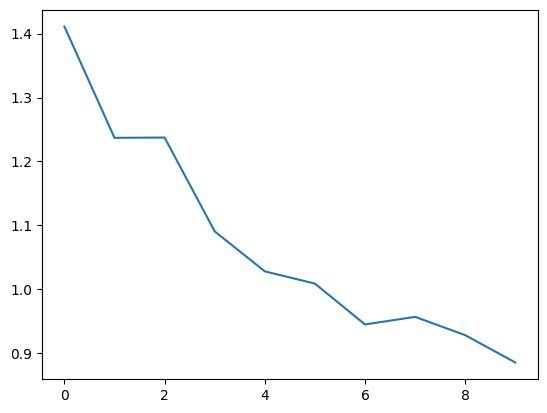

In [30]:
epoch_loss = [loss.item() for loss in epoch_loss] 
plt.plot(epoch_loss)
plt.show()

In [31]:
embedding_types = list(model.num_nodes_dict.keys())
idxs = list(model.num_nodes_dict.values())
idxs.insert(0, 0)

idxs = np.cumsum(idxs).tolist()
start_idxs = idxs[:-1]
end_idxs = idxs[1:]

assert len(embedding_types) == len(start_idxs)
assert len(start_idxs) == len(end_idxs)

idxs_dict = {emb_t: (start, end) for emb_t, start, end in zip(embedding_types, start_idxs, end_idxs)}
idxs_dict

{'user': (0, 671),
 'movie': (671, 9796),
 'actor': (9796, 25239),
 'genre': (25239, 25259)}

### Visualize in 2d/3d

In [32]:
user_embeddings = model.embedding.weight[idxs_dict['user'][0]:idxs_dict['user'][1], :]
movie_embeddings = model.embedding.weight[idxs_dict['movie'][0]:idxs_dict['movie'][1], :]
actor_embeddings = model.embedding.weight[idxs_dict['actor'][0]:idxs_dict['actor'][1], :]
genre_embeddings = model.embedding.weight[idxs_dict['genre'][0]:idxs_dict['genre'][1], :]

print(f'user_embeddings: {user_embeddings.size()}\nmovie_embeddings: {movie_embeddings.size()}\n' \
    f'actor_embeddings: {actor_embeddings.size()}\ngenre_embeddings: {genre_embeddings.size()}')

user_embeddings: torch.Size([671, 8])
movie_embeddings: torch.Size([9125, 8])
actor_embeddings: torch.Size([15443, 8])
genre_embeddings: torch.Size([20, 8])


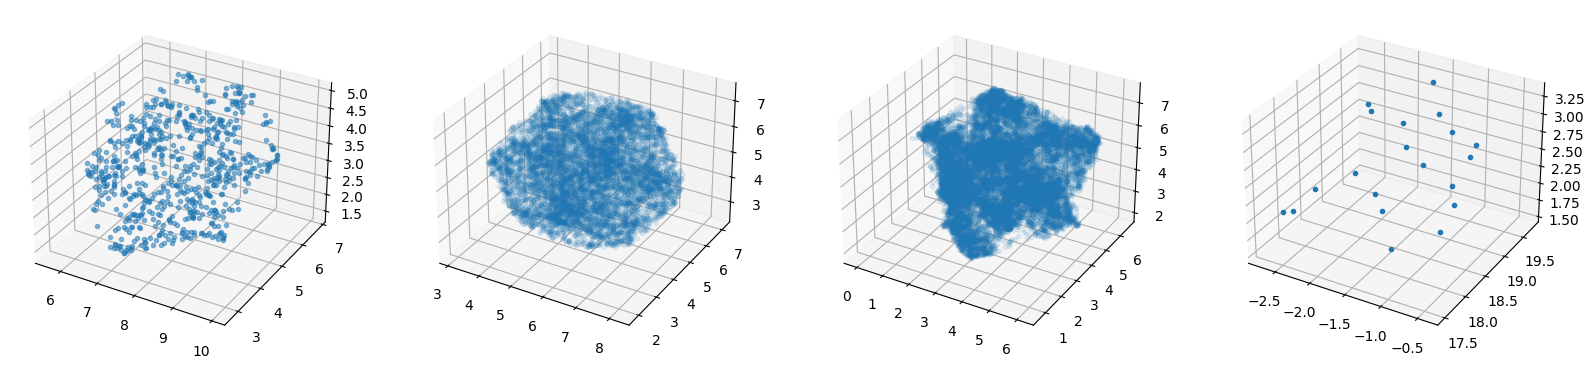

In [33]:
trans = UMAP(n_components=3, random_state=11)
# embeddings = model.embedding.weight.detach().numpy()
# trans = umap_3d.fit(embeddings)

# print('Calc user embedding reduction')
user_emb_trans = trans.fit_transform(user_embeddings.detach().numpy())
movie_emb_trans = trans.fit_transform(movie_embeddings.detach().numpy())
actor_emb_trans = trans.fit_transform(actor_embeddings.detach().numpy())
genre_emb_trans = trans.fit_transform(genre_embeddings.detach().numpy())

# user_emb_trans.shape, movie_emb_trans.shape, actor_emb_trans.shape, genre_emb_trans.shape

# plot
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4,nrows=1, figsize=(20, 40), subplot_kw=dict(projection='3d'))
ax0.plot(user_emb_trans[:,0], user_emb_trans[:,1], user_emb_trans[:,2], '.', label='User', alpha=0.5)
ax1.plot(movie_emb_trans[:,0], movie_emb_trans[:,1], movie_emb_trans[:,2], '.', label='Movie', alpha=0.1)
ax2.plot(actor_emb_trans[:,0], actor_emb_trans[:,1], actor_emb_trans[:,2], '.', label='Actor', alpha=0.1)
ax3.plot(genre_emb_trans[:,0], genre_emb_trans[:,1], genre_emb_trans[:,2], '.', label='Genre')

# ax.legend()
plt.show()


### Create PyG dataset with node embeddings 

In [34]:
data = HeteroData()

# nodes
data['user'].x = user_embeddings
data['movie'].x = movie_embeddings
data['actor'].x = actor_embeddings
# data['director'].x = x_director
data['genre'].x = genre_embeddings

# edge indecies
data[('user', 'rated', 'movie')].edge_index = edge_index_user_rated_movie
data[('actor', 'played_in', 'movie')].edge_index = edge_index_actor_playedIn_movie
# data[('director', 'directed', 'movie')].edge_index = edge_index_director_directed_movie
data[('movie', 'in', 'genre')].edge_index = edge_index_movie_in_genre

# edge labels
data[('user', 'rated', 'movie')].edge_label = edge_label_user_rated_movie

# add reverse edges
data = ToUndirected()(data)
del data[('movie', 'rev_rated', 'user')].edge_label

data

HeteroData(
  user={ x=[671, 8] },
  movie={ x=[9125, 8] },
  actor={ x=[15443, 8] },
  genre={ x=[20, 8] },
  (user, rated, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (actor, played_in, movie)={ edge_index=[2, 35910] },
  (movie, in, genre)={ edge_index=[2, 20340] },
  (movie, rev_rated, user)={ edge_index=[2, 100004] },
  (movie, rev_played_in, actor)={ edge_index=[2, 35910] },
  (genre, rev_in, movie)={ edge_index=[2, 20340] }
)

### Train/Test Split

In [35]:
# Perform a link-level split into training, validation, and test edges.
train_data, val_data, test_data = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rated', 'movie')],
    rev_edge_types=[('movie', 'rev_rated', 'user')],
)(data)

### Define the model

In [36]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin_out = Linear(hidden_channels, 1)
        
    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        # concat user and movie embeddings
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
        # concatenated embeddings passed to linear layer
        z = self.lin1(z).relu()
        z = self.lin_out(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


model = Model(hidden_channels=64).to(device)

In [37]:
# Due to lazy initialization, we need to run one model step so the number
# of parameters can be inferred:
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters())

In [38]:
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    # loss = weighted_mse_loss(pred, target, weight)
    loss = F.mse_loss(pred, target).sqrt()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [39]:
EPOCHS = 600
train_losses, val_losses, test_losses = [], [], []
for epoch in range(1, EPOCHS+1):
    train_loss = train()
    # train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    
    train_losses.append(train_loss), val_losses.append(val_rmse), test_losses.append(test_rmse)
    
    print(f'Epoch: {epoch:03d}\tTrain: {train_loss:.4f}\t'
          f'Val: {val_rmse:.4f}\tTest: {test_rmse:.4f}')
    # break

Epoch: 001	Train: 3.7231	Val: 3.5303	Test: 3.5218
Epoch: 002	Train: 3.5327	Val: 3.3287	Test: 3.3203
Epoch: 003	Train: 3.3306	Val: 3.1124	Test: 3.1043
Epoch: 004	Train: 3.1140	Val: 2.8768	Test: 2.8691
Epoch: 005	Train: 2.8781	Val: 2.6160	Test: 2.6085
Epoch: 006	Train: 2.6168	Val: 2.3262	Test: 2.3192
Epoch: 007	Train: 2.3267	Val: 2.0092	Test: 2.0032
Epoch: 008	Train: 2.0098	Val: 1.6771	Test: 1.6728
Epoch: 009	Train: 1.6784	Val: 1.3664	Test: 1.3652
Epoch: 010	Train: 1.3701	Val: 1.1699	Test: 1.1744
Epoch: 011	Train: 1.1792	Val: 1.2057	Test: 1.2156
Epoch: 012	Train: 1.2313	Val: 1.3618	Test: 1.3707
Epoch: 013	Train: 1.4329	Val: 1.4562	Test: 1.4639
Epoch: 014	Train: 1.5667	Val: 1.4650	Test: 1.4726
Epoch: 015	Train: 1.5757	Val: 1.4087	Test: 1.4167
Epoch: 016	Train: 1.4887	Val: 1.3107	Test: 1.3196
Epoch: 017	Train: 1.3548	Val: 1.2056	Test: 1.2150
Epoch: 018	Train: 1.2267	Val: 1.1376	Test: 1.1454
Epoch: 019	Train: 1.1499	Val: 1.1336	Test: 1.1387
Epoch: 020	Train: 1.1422	Val: 1.1759	Test: 1.1791


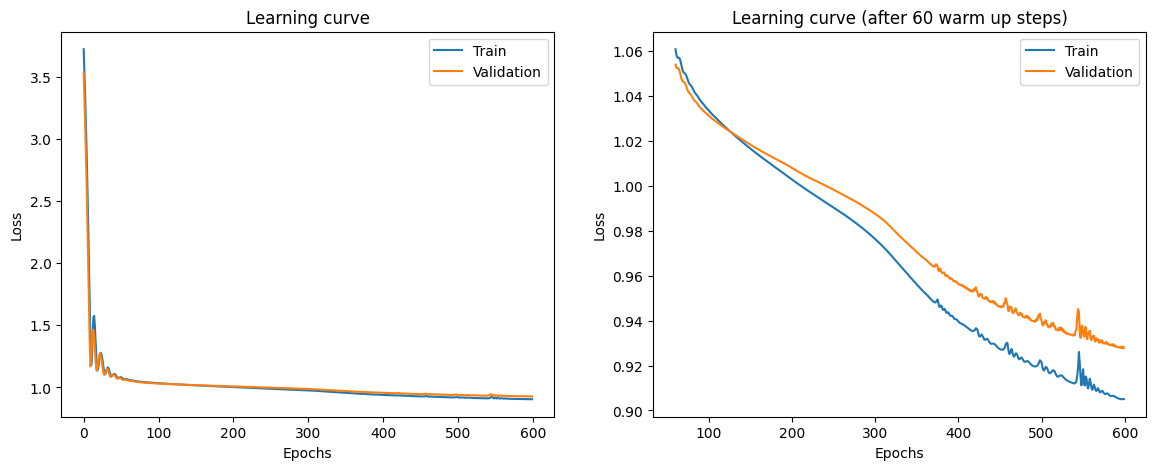

In [40]:
SKIP_WARM_UP_STEPS = 60

_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax0.plot(train_losses, label='Train')
ax0.plot(val_losses, label='Validation')
ax0.set_title('Learning curve')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Loss')
ax0.legend()

ax1.plot(range(SKIP_WARM_UP_STEPS, len(train_losses)), train_losses[SKIP_WARM_UP_STEPS:], label='Train')
ax1.plot(range(SKIP_WARM_UP_STEPS, len(train_losses)), val_losses[SKIP_WARM_UP_STEPS:], label='Validation')
ax1.set_title(f'Learning curve (after {SKIP_WARM_UP_STEPS} warm up steps)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
plt.show()